# Sohil Parsana-- Sample Data Cleaning for 4sight 

I have used technical discussions after most blocks of code and a summary/next steps towards the end of the notebook.

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import seaborn as sns
os.chdir("/content/drive/My Drive/Data/millenium")

In [23]:
data=pd.read_excel('Sample Dataset.xlsx')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB


There is no missing values in the data provided, the signal may be reliable.

In [25]:
data.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


The summary stats of the data. This helps to summarize the data distribution, and sample statistics.

The signal prices are always positive, thus they are shifted by some mean. In order to get a quick and better buy/sell/hold, this could to be scaled. 





In [26]:
data.isnull().sum()

Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

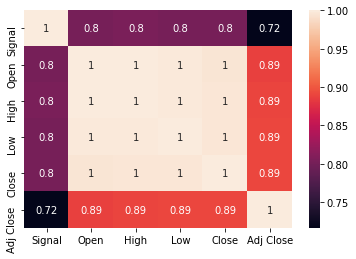

In [27]:
sns.heatmap(data.corr(),annot=True)

This correlation analysis shows the predicatability of the signal provided by 4sights. The coefficients range from -1 to 1, with 1 meaning there is perfect correlation between the actual market movement and its predicted movement from signal while -1 being actual market moved in the opposite direction than the signal prediction.

Thus, it is seen here that the signal is 80% effective in its prediction overall. The Open, High, Low, and Close all have correlation of 1, so it is safe to drop them and keep just one of them (here I'll keep close). Also, we can introduce a new measure spread to determine difference between high and low every day.

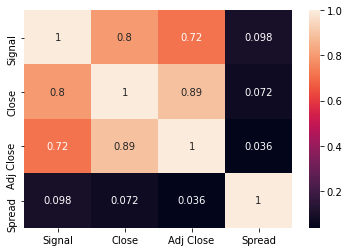

In [28]:
data['Spread']=data['High']-data['Low']
data=data.drop(columns=['Open','High','Low'])
sns.heatmap(data.corr(),annot=True)

The spread is not correlated with any other column. This can be used as an extra predictor as we do a multi-variate time series analysis at a later stage in this notebook. (However, I am not considering this at this point)

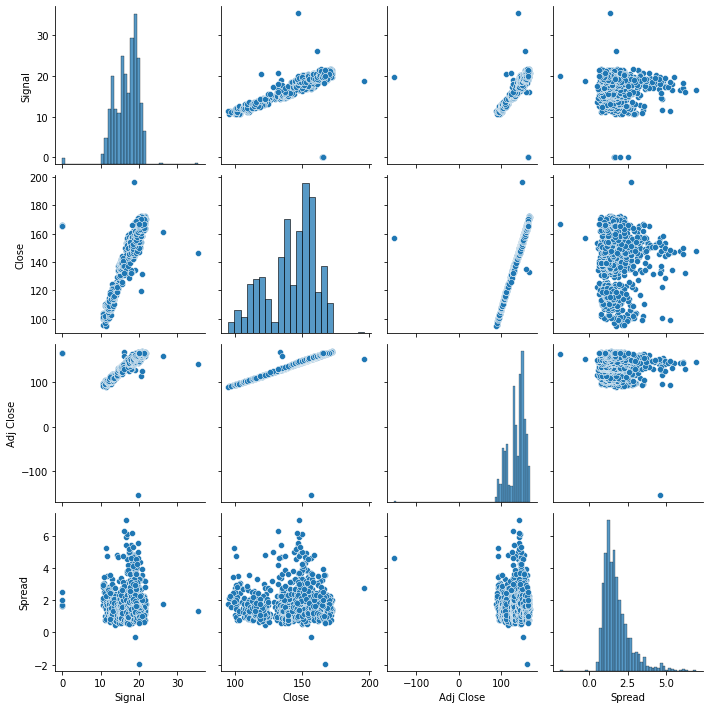

In [10]:
sns.pairplot(data)

Visualizing the variation of different columns in the data. The market prices variation with signal values is major focus for analysis. 
1. It is seen that the signal roughly follow a normal distribution. There are a few instances where it has yielded values which are very large or very small (can be considered outliers) which does not correspond to a major change in the actual movement of stock indices. This might be a potential source of error in the 4sight system as this anomalous behaviour might lead to a false sense of ETF price movement.
2. The Spread is a positive-skewed normal distribution. It is negative for a few cases which might be some discrepancy.

In [29]:
# Resample data daily and assign same stock/signal values for weekends
data=data.set_index('Date')
data=data.asfreq('d')
data=data.fillna(method='ffill')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


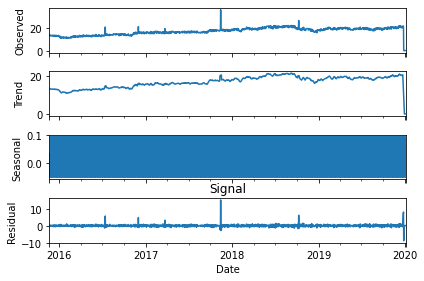

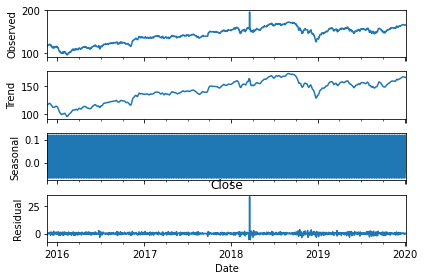

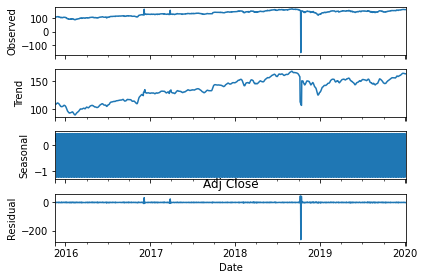

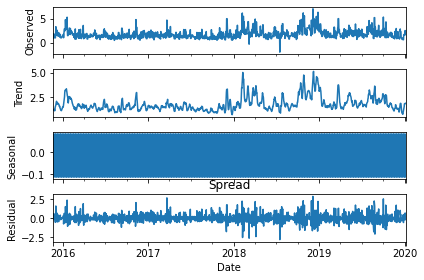

In [12]:
# Decompose the time series to get the components
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
for i in data.columns:
  result = seasonal_decompose(data[i], model='additive')
  result.plot()
  plt.title(str(i))
  plt.show()


As can be seen from the time series decomposition of Signal, Close, Adj Close, and Spread respectively, there is just drift and random noise in the data. No seasonality is present. This information helps in deciding potential ways of treating the signal data.  

A technique to analyze time series data is through autocorrelation plots and partial autocorrelation plots. Given our series does not have a seasonal component, these plots help in identifying the orders of AR (autoregressive) and MA (moving average) if we were to model the time series using classical approaches. 

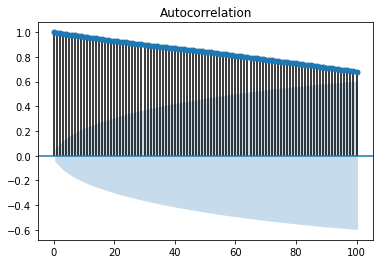

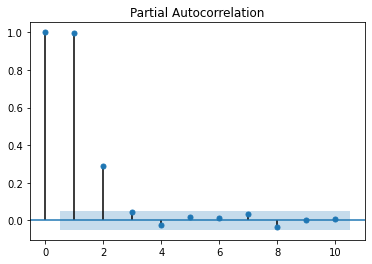

In [31]:
#Plot for Close data
import statsmodels.api as sm
# ACF Plot of Target Variable
sm.graphics.tsa.plot_acf(data['Close'],lags= 100)
sm.graphics.tsa.plot_pacf(data['Close'],lags= 10)
plt.show()

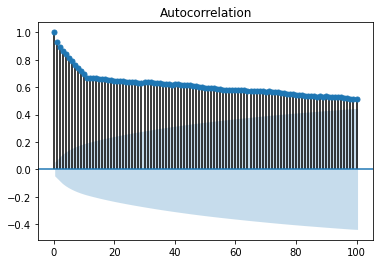

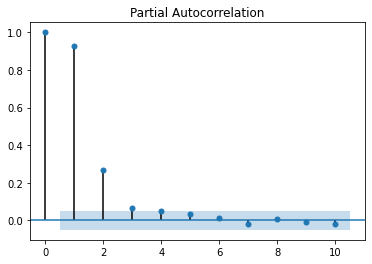

In [19]:
#Plot for Signal
sm.graphics.tsa.plot_acf(data['Signal'],lags= 100)
sm.graphics.tsa.plot_pacf(data['Signal'],lags= 10)

plt.show()

From these acf and Pacf plots, it is clear that the close and Signal data are AR series as acf is a geometric decay while pacf is significant upto p lags. For both time series, p is 3 and hence it is AR(3) series. Moreover, the acf doesn't decay after many lags indicating that these series are non-stationary.

In [ ]:
# Better visualization of the time series
import plotly.express as px
fig = px.line(data,x=data.index, y='Signal', title='Signal with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
import plotly.express as px
fig = px.line(data,x=data.index, y='Close', title='Close with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Visualizing the Signal data. You may use the slider to focus on a particular period. The outliers found in the Signal data can be clearly seen using this visualization.

## Analysing effectiveness of Signal

It was seen that there are outliers in Signal. One way is to use linear interpolating the outliers. However, in this does not capture the non-linearities and a better choice is median filtering which is non-linear digital filtering helpful in removing noises from time series. We use median filtering to remove them.

In [32]:
# Employ median filtering and removing points where magnitude of z-score is more than 3.
from scipy.signal import medfilt
from scipy import stats
data['filter_sig']=medfilt(data['Signal'])
data=data[~(abs(stats.zscore(data['filter_sig']))>3)]


To compare the effectiveness of Signal for 'Close' data, stationarity must be ensured. Also, the two time series have different scales, so standardization can be performed. A standardized signal data also gives us an intuition as to the direction of the movement of the stock.

In [33]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

def Standardize(series):
  values = series.values
  values = values.reshape((len(values), 1))
  # train the standardization
  scaler = StandardScaler()
  scaler = scaler.fit(values)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
  # standardization the dataset and print the first 5 rows
  normalized = pd.DataFrame(scaler.transform(values))
  normalized.index=series.index
  return normalized



In [34]:
norm_close=Standardize(data['Close'])
norm_signal=Standardize(data['filter_sig'])


Mean: 141.590033, StandardDeviation: 18.412599
Mean: 16.833104, StandardDeviation: 2.737231


Next, we want to check if the signal data has a causality with the Close time series. We use Granger Test for this analysis. If the test is failed, we won't have statistical evidence that the 

In [37]:
## Granger Test to see if the signal can used to forecast the Close value
from statsmodels.tsa.stattools import grangercausalitytests
test=pd.DataFrame()
test['Close']=np.diff(norm_close[0])[1:] # Stationary
test['signal']=np.diff(norm_signal[0])[1:]# Stationary
test.index=data.index[2:]
gc_res = grangercausalitytests(test, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0030  , p=0.3168  , df_denom=1493, df_num=1
ssr based chi2 test:   chi2=1.0050  , p=0.3161  , df=1
likelihood ratio test: chi2=1.0047  , p=0.3162  , df=1
parameter F test:         F=1.0030  , p=0.3168  , df_denom=1493, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5272  , p=0.5903  , df_denom=1490, df_num=2
ssr based chi2 test:   chi2=1.0580  , p=0.5892  , df=2
likelihood ratio test: chi2=1.0577  , p=0.5893  , df=2
parameter F test:         F=0.5272  , p=0.5903  , df_denom=1490, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6109  , p=0.6079  , df_denom=1487, df_num=3
ssr based chi2 test:   chi2=1.8414  , p=0.6060  , df=3
likelihood ratio test: chi2=1.8403  , p=0.6062  , df=3
parameter F test:         F=0.6109  , p=0.6079  , df_denom=1487, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6298  , p=0.

It is seen here that the signal data grangercauses the Close data, with p-value<0.05, we can reject the null hypothesis and conclude that past value of signal data do in fact have statistically significant affect on current value of close data from lag 6 onwards.

Thus, with this analysis it is clear that this modified time series is effective in forecasting the ETF price. Lag of 6 (safe side would be 7) can be considered to forecast the close price as indicated by F and p-test. Hence, we can be confident that signal data should be used to forecast the close data.


## Forecasting using LSTM

We figured pre-processing steps for the signal and close data time series. In order to see if the signal data is effective, we can train a forecasting model that takes in input from past data of the signal and the close time series and forecast the next value of close data.

Since the series are non-stationary and modelling is multivariate,a good choice would be to use deep learning based models which can handle such data. LSTMs have been popular for such tasks as they learn temporal behavior of data and have found considerable success over traditional ARIMA based models. They are less brittle to non-linearities in data and capturing similarities between different lags.

In [ ]:
data1=data.copy()
data1['out']=data1.Close.shift(1).dropna()
data1=data1.dropna()

In [ ]:
n=data1.shape[0]
x_tr, x_te = np.array(data1.iloc[0:int(0.8*n),[0,1]]), np.array(data1.iloc[int(0.8*n):,[0,1]])
y_train,y_test=np.array(data1.iloc[0:int(0.8*n),5]), np.array(data1.iloc[int(0.8*n):,5])
x_train=x_train.reshape(-1,x_tr.shape[1],1)
x_test=x_test.reshape(-1,x_te.shape[1],1)
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)


In [ ]:
x_test.shape,x_train.shape,y_test.shape,y_train.shape

((300, 2, 1), (1198, 2, 1), (300, 1), (1198, 1))

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.layers import BatchNormalization

In [ ]:
def LSTM_model(x_train,y_train,x_test,y_test):
  tf.random.set_seed(1)
  model = Sequential()
  #Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 16, return_sequences = True, input_shape = (x_train.shape[1],1)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 4))
  model.add(BatchNormalization())
  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-2,
      decay_steps=10000,
      decay_rate=0.9)
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(optimizer = optimizer, loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  history=model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs = 30, batch_size = 32)
  return history,model

In [ ]:
history,model=LSTM_model(x_train,y_train,x_test,y_test)

Epoch 1/30
38/38 [==============================] - 6s 50ms/step - loss: 19298.1359 - val_loss: 22905.9570
Epoch 2/30
38/38 [==============================] - 0s 7ms/step - loss: 18343.6079 - val_loss: 21342.6328
Epoch 3/30
38/38 [==============================] - 0s 8ms/step - loss: 16997.2658 - val_loss: 19436.1543
Epoch 4/30
38/38 [==============================] - 0s 7ms/step - loss: 15367.3125 - val_loss: 16853.7832
Epoch 5/30
38/38 [==============================] - 0s 7ms/step - loss: 12918.8736 - val_loss: 14107.9668
Epoch 6/30
38/38 [==============================] - 0s 7ms/step - loss: 10156.6095 - val_loss: 10031.2998
Epoch 7/30
38/38 [==============================] - 0s 8ms/step - loss: 7475.1370 - val_loss: 7644.4517
Epoch 8/30
38/38 [==============================] - 0s 7ms/step - loss: 5432.0392 - val_loss: 4448.1665
Epoch 9/30
38/38 [==============================] - 0s 7ms/step - loss: 3353.5229 - val_loss: 3116.6086
Epoch 10/30
38/38 [==============================] 

dict_keys(['loss', 'val_loss'])


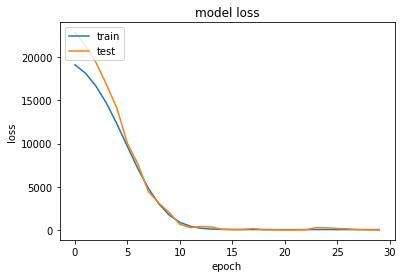

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<function matplotlib.pyplot.show>

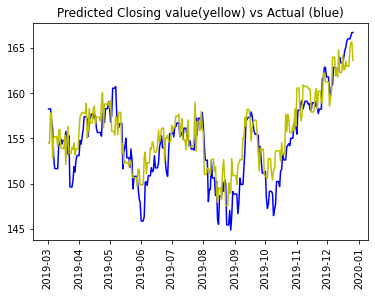

In [ ]:
y_pred=[t[0] for t in model.predict(x_test)]
yt=pd.DataFrame()
yt['y_test']=[t[0] for t in y_test]
yt['y_pred']=y_pred
yt.index=data1.iloc[int(0.8*n):,[0,1]].index
plt.plot(y['y_test'],'b')#blue
plt.plot(y['y_pred'],'y')#yellow
plt.title('Predicted Closing value(yellow) vs Actual (blue)')
plt.xticks(rotation=90)
plt.show

From the predictions shown above, our baseline LSTM model is pretty accurate in forecasting the Close data, even without much fine-tuning!

# Summary and recommendation for next steps for Portfolio Manager

The above exercise elucidates the data cleaning and the next steps in the analysis of the data. To summarize:
1. The data provided has completeness, i.e, there are no empty fields or missing data. Also, the signal and indices have a trend and residuals, but no seasonality. 
2. The signal data has a high positive correlation with stock indices, so it should be analyzed further. The signal data is mean shifted, i.e, you need to apply transformation in order to assess the implication of its value.
3. The signal data has outliers of two types-occuring randomly and occuring due to (potential) failure of the 4sight system. The first type can be treated by median filtering and standardizing, while the second type needs to be removed from data (absolute z-score>3). Another way to filter the second type is that values in this case are consistently zero for some continuous time period.
4. The scale of signal and close data are different. Standardizing the two series is useful to perform any kind of statistical check or run modelling.
5.Running a Granger causality test shows the signal time series is statistically significant for estimating and forecasting the stock close data. This proves efficacy and believability of the product.
7. Using this information, we can train a multivariate time series for forecasting. I show the same by training a baseline LSTM net to forecast close data. A good next step would be use higher lags as input for forecasting and fine tuning model performance.
8. Thus it can be concluded that there is merit in using the 4ight's signal data. The next steps could be improving this model to not just get better forecast but also generate confidence error associated with predictions. This can be done using bayesian neural netword for time series. A better way to deal with scenarios where the 4sight signal yields zeros (breakdowns) needs to be analyzed.

